In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ╔════════════════════════════════╗
# ║ 1.  Install / import packages  ║
# ╚════════════════════════════════╝
!pip install --quiet scikit-learn pandas matplotlib seaborn imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib


In [ ]:
# ╔═══════════════════════════════╗
# ║ 2.  Load & inspect the data   ║
# ╚═══════════════════════════════╝
PATH = '/content/drive/MyDrive/heart disease.csv'      # change if needed
df = pd.read_csv(PATH)

print("Shape :", df.shape)
display(df.head())          # quick look
df.info()                   # dtypes / missing values


Shape : (1190, 12)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


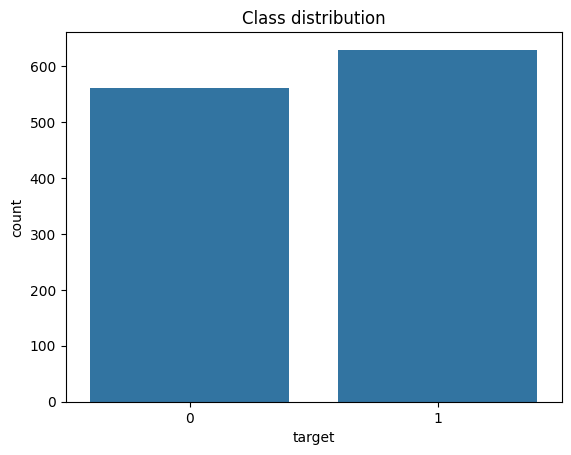

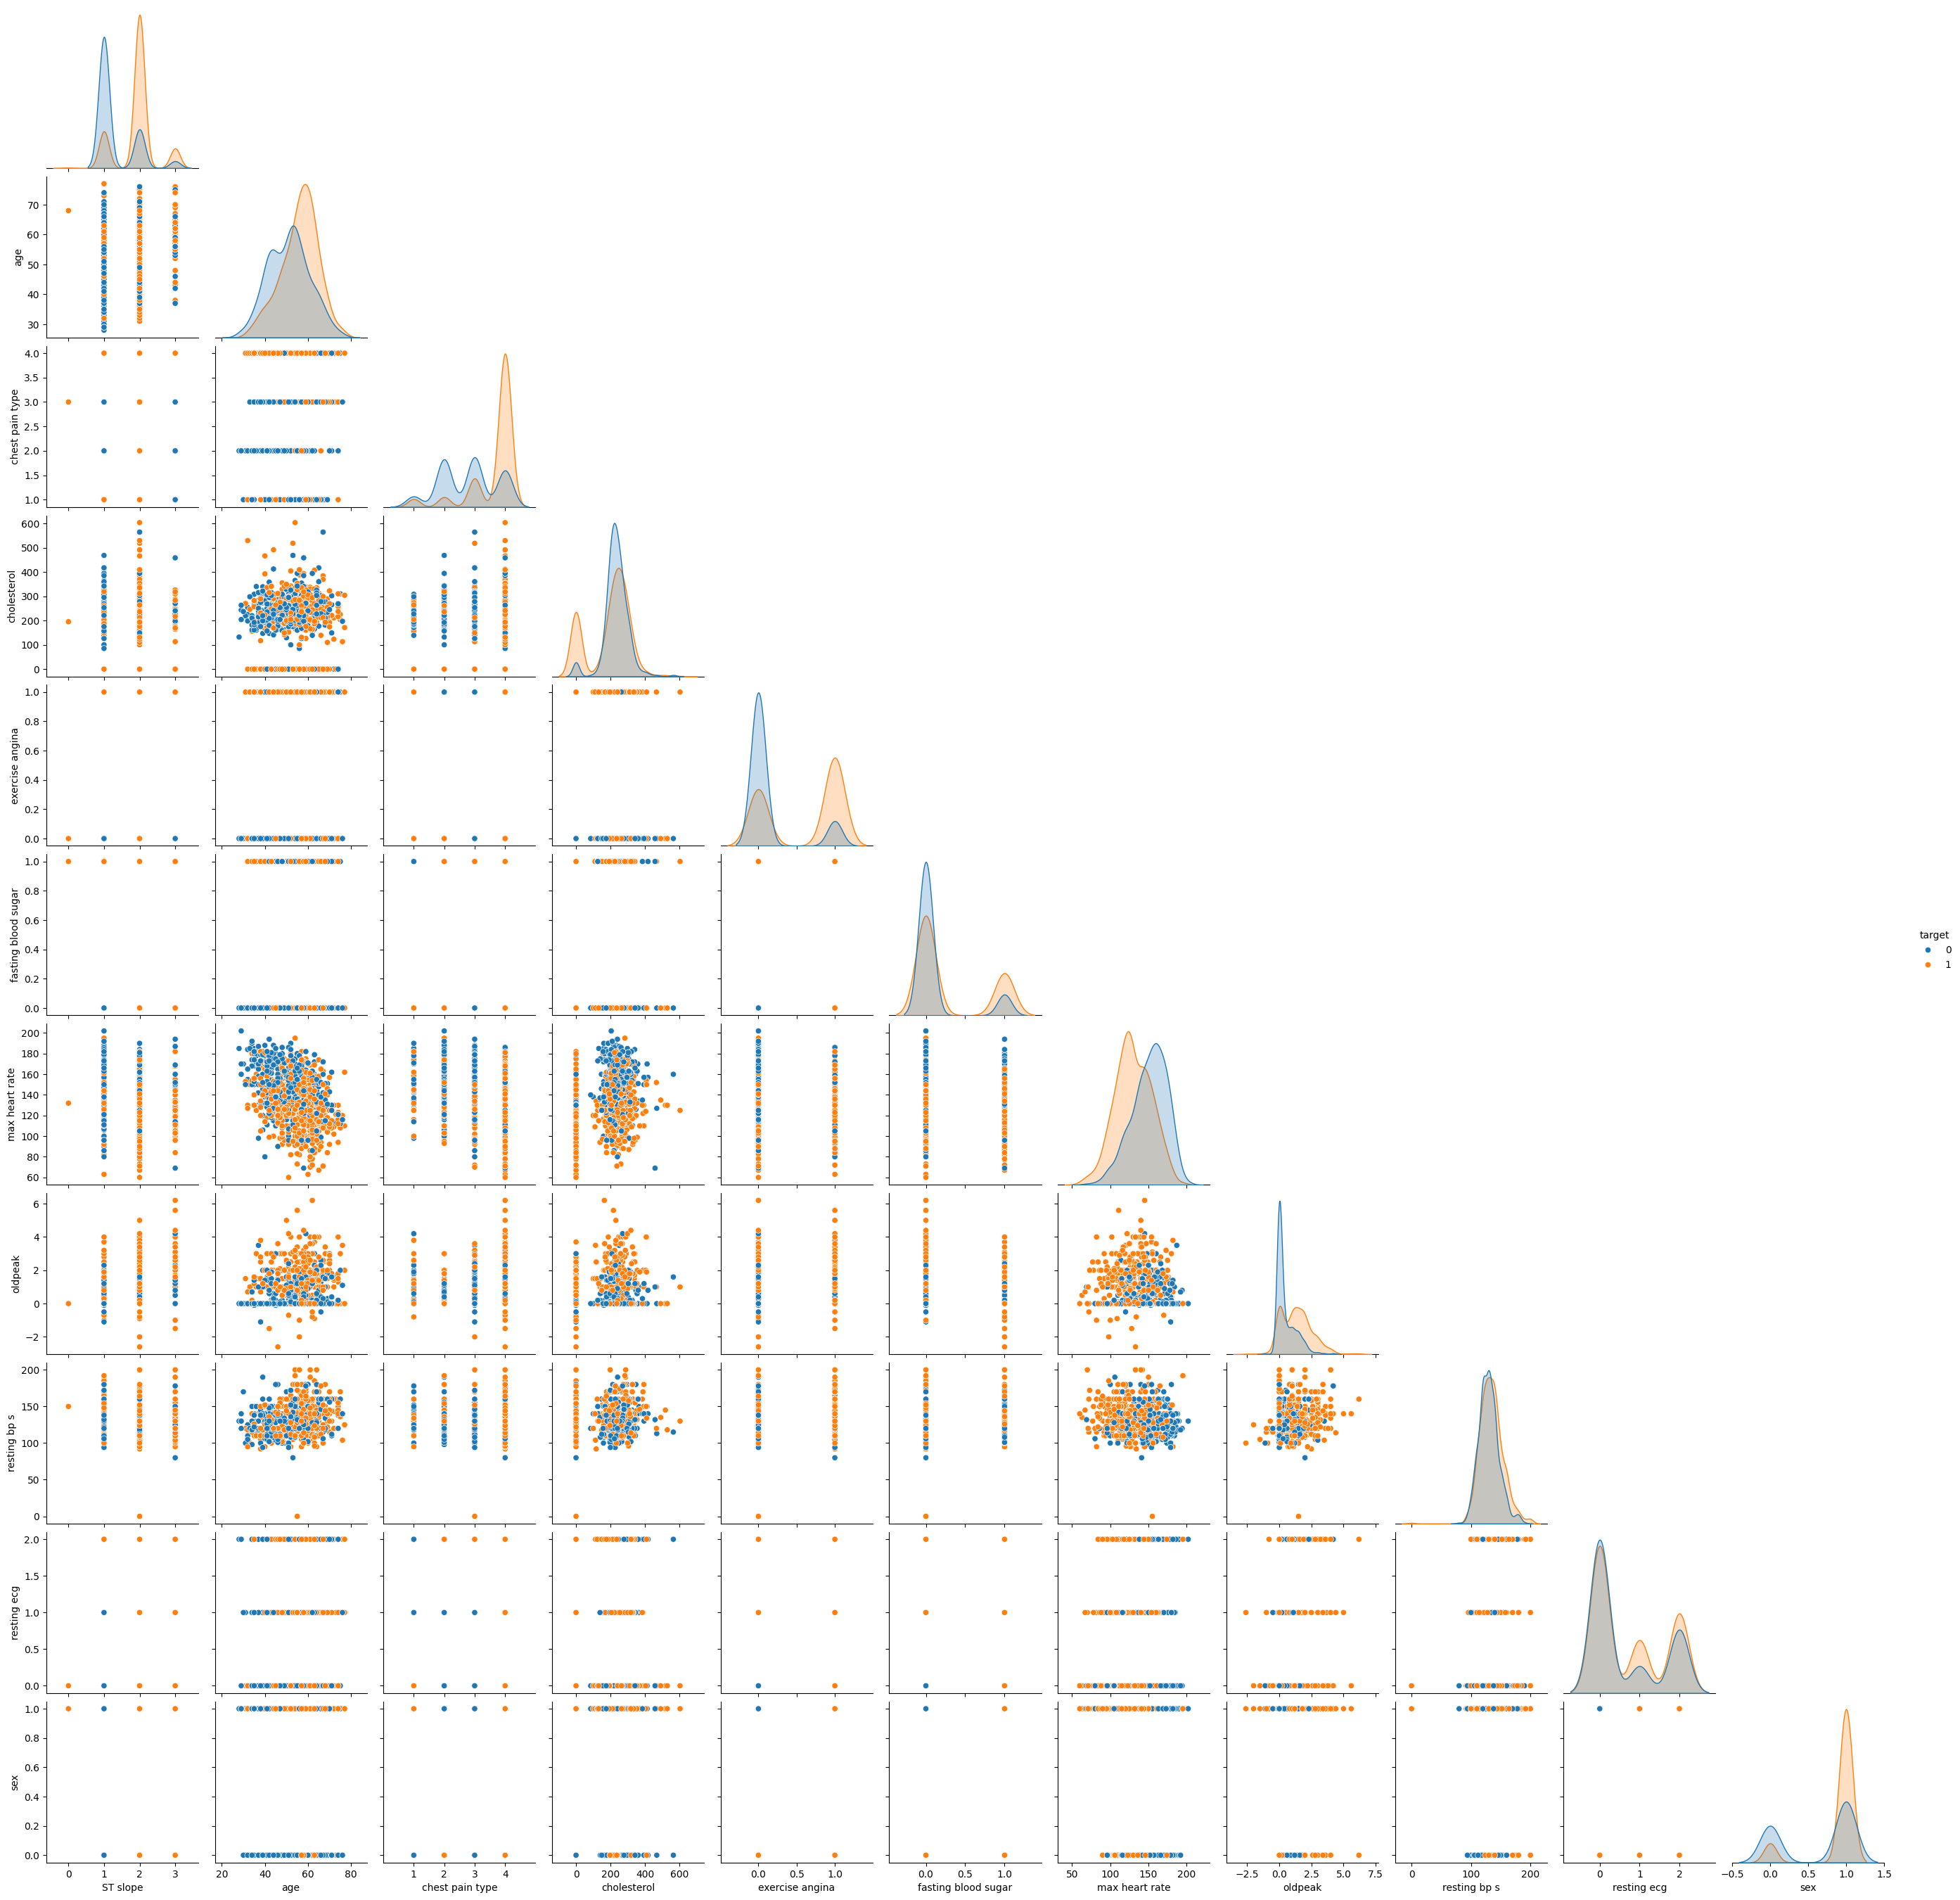

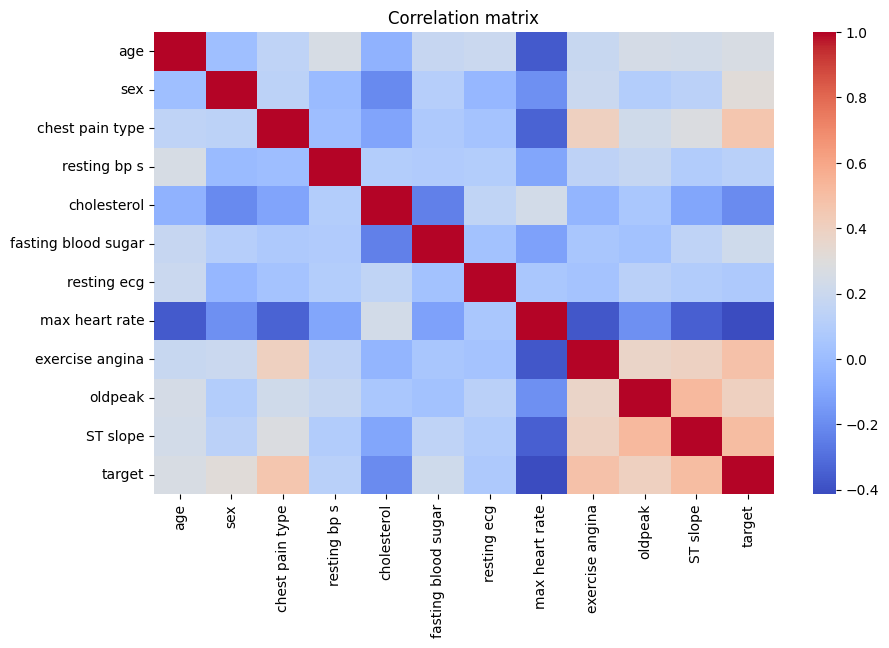

In [ ]:
# ╔════════════════════════════════════════╗
# ║ 3.  Basic EDA (pairplot & heat‑map)    ║
# ╚════════════════════════════════════════╝
sns.countplot(data=df, x='target'); plt.title('Class distribution'); plt.show()

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(df[numeric_cols.union(['target'])], hue='target', corner=True)
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [ ]:
# ╔══════════════════════════════════╗
# ║ 4.  Train/validation/test split  ║
# ╚══════════════════════════════════╝
X = df.drop('target', axis=1)
y = df['target']

# 60% train, 20% val, 20% test (stratified)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (714, 11) Val: (238, 11) Test: (238, 11)


In [ ]:
# ╔════════════════════════════════╗
# ║ 5.  Pre‑processing pipeline    ║
# ╚════════════════════════════════╝
# Separate feature lists
num_feats  = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats  = X.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_feats)
    ])


In [ ]:
# ╔══════════════════════╗
# ║ 6‑A.  Logistic       ║
# ╚══════════════════════╝
log_clf = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', LogisticRegression(max_iter=200, class_weight='balanced'))
])

log_clf.fit(X_train, y_train)
val_pred = log_clf.predict(X_val)

print("Logistic Regression (val):")
print(classification_report(y_val, val_pred))


Logistic Regression (val):
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       112
           1       0.89      0.87      0.88       126

    accuracy                           0.87       238
   macro avg       0.87      0.87      0.87       238
weighted avg       0.87      0.87      0.87       238



In [ ]:
# ╔══════════════════════╗
# ║ 6‑B.  Random Forest  ║
# ╚══════════════════════╝
param_grid = {
    'model__n_estimators':[100,250],
    'model__max_depth':[None,5,10]
}

rf_clf = Pipeline(steps=[
        ('prep', preprocessor),
        ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

grid = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)
best_rf = grid.best_estimator_

val_pred_rf = best_rf.predict(X_val)
print("Random Forest (val):")
print(classification_report(y_val, val_pred_rf))


Best RF params: {'model__max_depth': None, 'model__n_estimators': 250}
Random Forest (val):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       112
           1       0.91      0.94      0.93       126

    accuracy                           0.92       238
   macro avg       0.92      0.92      0.92       238
weighted avg       0.92      0.92      0.92       238




LogReg ‑ Test AUC: 0.906
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       112
           1       0.85      0.84      0.85       126

    accuracy                           0.84       238
   macro avg       0.84      0.84      0.84       238
weighted avg       0.84      0.84      0.84       238


RandForest ‑ Test AUC: 0.959
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       112
           1       0.90      0.93      0.91       126

    accuracy                           0.91       238
   macro avg       0.91      0.91      0.91       238
weighted avg       0.91      0.91      0.91       238



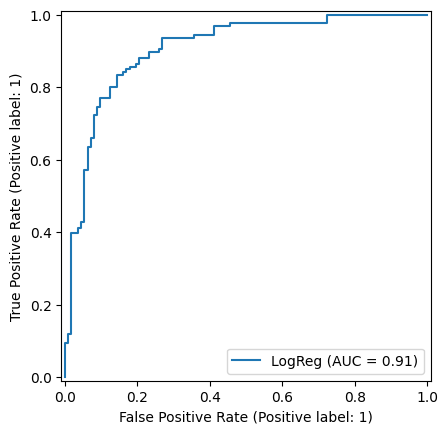

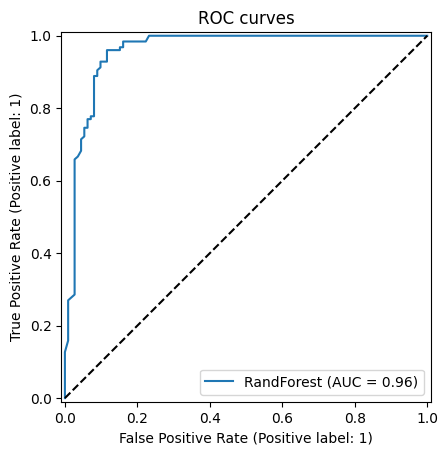

In [ ]:
# ╔══════════════════════╗
# ║ 7.  Test‑set scores  ║
# ╚══════════════════════╝
for name, model in [('LogReg', log_clf), ('RandForest', best_rf)]:
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred  = (y_proba > 0.5).astype(int)   # threshold 0.5
    print(f"\n{name} ‑ Test AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print(classification_report(y_test, y_pred))

    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
plt.plot([0,1],[0,1],'k--'); plt.title('ROC curves'); plt.show()


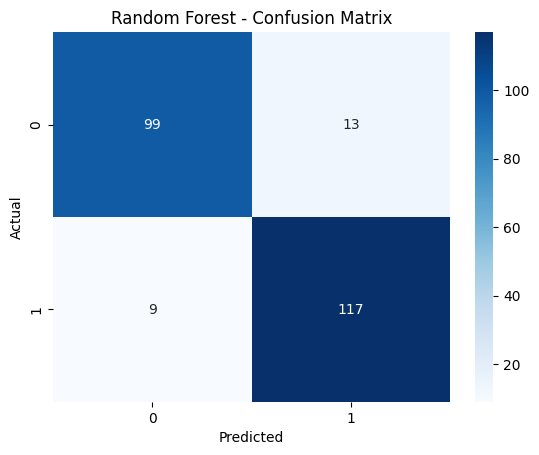

In [ ]:
# ╔═══════════════════╗
# ║ 8.  Confusion matrix
# ╚═══════════════════╝
sns.heatmap(confusion_matrix(y_test, best_rf.predict(X_test)),
            annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest ‑ Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()


In [ ]:
# ╔══════════════════════════╗
# ║ 9.  Save the best model  ║
# ╚══════════════════════════╝
joblib.dump(best_rf, 'heart_model.pkl')
print("Model saved as heart_model.pkl")


Model saved as heart_model.pkl
